In [1]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Atom, BondType

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import cm
from matplotlib.colors import ListedColormap

import pandas as pd

In [2]:
def amat_entry(amat,r,c,val):
    """
    changes the (r,c) and (c,r) values of matrix "amat" to "val"
    """
    amat[r-1][c-1] = amat[c-1][r-1]= val
    return

In [3]:
def amat_edit(amat,r,c,delta):
    """
    changes the (r,c) and (c,r) values of matrix "amat" to "val"
    """
    amat[r-1][c-1] += delta
    if r != c:
        amat[c-1][r-1] += delta
    return

In [4]:
def molFromAdjMat(atoms, amat,sanitize=True):
    """Creates a mol object from an adjacency matrix.
    Inputs:
    atoms: list of atomic numbers of atoms, by row
    amat: adjacency matrix. Has to have same length as atoms (obviously)
    Output: mol object
    Might need to add a try clause for sanitize"""
    
    m = Chem.RWMol()
    # add in the separate atoms
    for a in atoms: m.AddAtom(Atom(a))
    side_len = len(amat)    
    for r in range(side_len):
        for c in range(r+1,side_len):
            bond_order = amat[r][c]
            if bond_order > 0:
                if bond_order == 1: m.AddBond(r,c,BondType.SINGLE)
                if bond_order == 2: m.AddBond(r,c,BondType.DOUBLE)
                if bond_order == 3: m.AddBond(r,c,BondType.TRIPLE)

    if sanitize:
        Chem.SanitizeMol(m)
    return m

In [5]:
def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx()+1)
    return mol

In [6]:
def make_changelogs(data_file_path):
    data = pd.read_csv(data_file_path)[["bond","edit","file"]]
    data = data[~data.bond.isnull()].copy()
    
    changelogs = []
    entry = {}
    bond_edits = ()
    for r in data.itertuples():


        # reset entry dict at new step
        if r[1] == "step":
            entry["edits"] = bond_edits
            changelogs.append(entry)
            entry = {}

        # if padding, fill th
        elif r[1] == "pad":
            pad_atoms = r[3].split(" ")
            pad_atoms = [int(i) for i in pad_atoms]

            if pad_atoms == [0]:
                entry["pad"] = 0
                entry["pad_elem"] = []

            else:
                entry["pad"] = len(pad_atoms)
                entry["pad_elem"] = pad_atoms

            # make the empty bond edits here to prepare
            bond_edits = []
        else:
            bond_edits.append((int(r[1]),int(r[2]),int(r[3])))
    
    return changelogs

In [7]:
def apply_changes(amat_init, atoms_init,changelogs):
    seq_out = [amat_init.copy()]
    amat = amat_init.copy()
    atoms = atoms_init.copy()
    for i in changelogs:
#         try:
            
        pad_amt = i["pad"]

        if pad_amt > 0:
            amat = np.pad(amat,[(0, pad_amt), (0, pad_amt)],  mode="constant")
            atoms.extend(i["pad_elem"])

        for ed in i["edits"]:
            amat_edit(amat,ed[0],ed[1],ed[2])
        seq_out.append(amat.copy())
            
#         except:
#             print(i)
        
    seq_out.reverse()
    
    all_sizes = [m.shape[0] for m in seq_out]
    max_size = max(all_sizes)

    output_padded = []

    for mat in seq_out:
        mat_size = mat.shape[0]
        if mat_size < max_size:
            pad_size = max_size - mat_size 
            output_padded.append(np.pad(mat, [(0, pad_size), (0, pad_size)], mode='constant'))
        else:
            output_padded.append(mat)
            
        
    return output_padded,atoms
    

## initialize

In [8]:
target_smiles = "CN1C(C2CO3)[C@@H]4[C@]5(C(C=CC=C6)=C6NC5=O)[C@H]3C[C@H]2[C@]4(C=C)C1"
target = Chem.MolToSmiles(Chem.MolFromSmiles(target_smiles))
target = Chem.MolFromSmiles(target)
Chem.Kekulize(target,clearAromaticFlags=True)

In [9]:
target_atoms = [atm.GetAtomicNum() for atm in target.GetAtoms()]
target_symbs = [atm.GetSymbol() for atm in target.GetAtoms()]

In [10]:
amat = Chem.GetAdjacencyMatrix(target,useBO=True,force=True)
amat_init = Chem.GetAdjacencyMatrix(target,useBO=True,force=True)

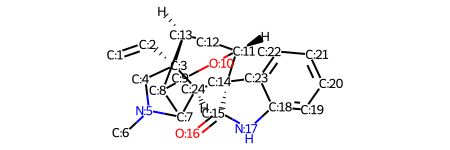

In [11]:
mol_with_atom_index(target)

### start the reversing


In [12]:
changelogs = make_changelogs("./edit_files/edits_gelsemine_synthia.csv")
changelogs[:3]

[{'edits': ()},
 {'pad': 0,
  'pad_elem': [],
  'edits': [(3, 3, 1),
   (7, 7, 1),
   (8, 8, 1),
   (11, 11, 1),
   (13, 13, 1),
   (14, 14, 1),
   (24, 24, 1)]},
 {'pad': 1, 'pad_elem': [8], 'edits': [(9, 10, -1), (9, 25, 1)]}]

In [13]:
out_1,final_atoms_1 = apply_changes(amat_init, target_atoms,changelogs[1:])

In [14]:
from rdkit.Chem.Draw import *
for i in range( len(out_1)):
    print(i)
    m = molFromAdjMat(final_atoms_1,out_1[i],sanitize=False)
    Chem.SanitizeMol(m)
    print(Chem.MolToSmiles(m))

0
C.C#CC.C=CC=O.CN.COC(C=O)=C1C(=O)Nc2ccccc21.O=CCCBr
1
C.C.C#CC.C=CC(N)C(C=O)CBr.COC(C=O)=C1C(=O)Nc2ccccc21.O
2
C.C.C#CC.C=CC(N)C(CO)CBr.COC(C=O)=C1C(=O)Nc2ccccc21.O
3
C.C.C#CCNC(C=C)C(CO)CBr.COC(C=O)=C1C(=O)Nc2ccccc21.O
4
C.C.C=CC1=CC(C(CO)CBr)NC1.COC(C=O)=C1C(=O)Nc2ccccc21.O
5
Br.C.C.C=CC1=CC(C(C=CC(OC)=C2C(=O)Nc3ccccc32)CO)NC1.O.O
6
Br.C.C.C=CC12CNC3C(CO)C1C=C(OC)C1(C(=O)Nc4ccccc41)C32.O.O
7
Br.C.C=CC12CN(C)C3C(CO)C1C=C(OC)C1(C(=O)Nc4ccccc41)C32.O.O
8
Br.C.C.C=CC12CN(C)C3C(CO)C1CC(=O)C1(C(=O)Nc4ccccc41)C32.O.O
9
Br.C.C.C=CC12CN(C)C3C(CO)C1CC(O)C1(C(=O)Nc4ccccc41)C32.O.O
10
Br.C.C.C=CC12CN(C)C3C4COC(CC41)C1(C(=O)Nc4ccccc41)C32.O.O.O
11
Br.C.C.C=CC12CN(C)C3C4COC(CC41)C1(C(=O)Nc4ccccc41)C32.O.O.O


In [15]:
save_dict = {"amats":out_1[:-1],"atoms":final_atoms_1}


In [16]:
np.savez("./matrices/gelsemine_synthia",**save_dict)